# Eulerian Video Magnification for Health Monitoring

In [ ]:
# all imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks
import time

## **Signal Processing**


#### **Butterworth Bandpass Filter**
The Butterworth filter is used for smooth signal filtering without introducing ripples in the passband.

$$
H(f) = \frac{1}{\sqrt{1 + \left(\frac{f}{f_c}\right)^{2n}}}
$$

Where:
- \( f \): Signal frequency
- \( f_c \): Cutoff frequency
- \( n \): Filter order (typically 5)

The filter design is performed using SciPy's `butter()` function:
```python
b, a = butter(order, [low, high], btype="band")
y = lfilter(b, a, data)
```


## **Signal Magnification**
After filtering, the pulse and breathing signals are magnified to enhance visibility:

$$
S_{\text{magnified}}(t) = S_{\text{filtered}}(t) \times A
$$

Where:
- $ S_{\text{filtered}}(t) $ : The filtered signal at time \( t \)
- \( A \): Magnification factor (set for breathing and pulse)

python```
    # Magnify Signals
    magnified_breathing = filtered_breathing * breath_amp
    magnified_pulse = filtered_pulse * pulse_amp
```


## **Peak Detection for Breathing and Pulse Rates**
We detect peaks in the filtered signals to estimate the breathing and pulse rates using SciPy’s `find_peaks()` method:

$$
R_{\text{rate}} = \frac{N_{\text{peaks}}}{T} \times 60
$$

Where:
- $( N_{\text{peaks}} )$: Number of detected peaks
- \( T \): Total duration in seconds
- \( 60 \): Conversion factor to minutes

```python
breath_peaks, _ = find_peaks(magnified_breathing, distance=fps * 2)
breathing_rate = (len(breath_peaks) / (len(avg_intensities) / fps)) * 60
```

4. **Rate Calculation:**

   - Breathing Rate:

$$
\text{Breathing Rate (BPM)} = \frac{\text{Number of Peaks Detected}}{\text{Total Duration}} \times 60
$$

- Pulse Rate:

  $$
  \text{Pulse Rate (BPM)} = \frac{\text{Number of Detected Peaks}}{\text{Total Duration}} \times 60
  $$


## **Irregularity Score**
The irregularity score measures variability in breathing intervals. It is computed using the standard deviation of breathing intervals:

$$
I_{\text{score}} = \sigma(\Delta T_{\text{breathing}})
$$

Where:
- $( \Delta T_{\text{breathing}} )$: Differences between successive breath peaks
- $( \sigma )$: Standard deviation


#### **Stress Detection Logic**
Based on empirical thresholds, stress detection is determined using:

- Pulse Rate > 100 BPM
- Breathing Rate > 20 BPM
- Irregularity Score > 1.5

```python
if pulse_rate > 100 or breath_rate > 20 or irregularity_score > 1.5:
    stress_status = "Stressed"
else:
    stress_status = "Normal"
```



### **5. Results Interpretation**
- **Breathing Rate:** Measured in Breaths Per Minute (BPM).
- **Pulse Rate:** Measured in Beats Per Minute (BPM).
- **Irregularity Score:** Standard deviation of breathing intervals.
- **Stress Status:** Either "Stressed" or "Normal" based on thresholds.





### **6. Visualization Breakdown**
1. **Breathing and Pulse Signals:**
   - **X-Axis:** Frame number
   - **Y-Axis:** Magnified Intensity

2. **Scan Line Visualizations:**
   - **Original Scan Line:** Before magnification
   - **Magnified Scan Line:** After applying EVM




# **How It Works**
### **Main Steps Involved:**
1. **Video Input:**
   - Video is captured from a file or webcam.
   
2. **Signal Extraction:**
   - Average intensities are computed for the whole frame.
   - Center vertical scan line intensities are extracted.

3. **Signal Processing:**
   - Bandpass filtering isolates breathing and pulse frequencies.
   - The signals are magnified for better visibility.

4. **Rate Calculation:**
   - Breathing Rate:
     \[
     \text{Breathing Rate (BPM)} = \frac{\text{Number of Peaks Detected}}{\text{Total Duration}} \times 60
     \]
   
   - Pulse Rate:
     \[
     \text{Pulse Rate (BPM)} = \frac{\text{Number of Detected Peaks}}{\text{Total Duration}} \times 60
     \]

5. **Irregularity Score:**
   - Standard deviation of breathing intervals:
     \[
     I_{\text{score}} = \sigma(\Delta T_{\text{breathing}})
     \]

6. **Stress Detection Logic:**
   - If pulse > 100 BPM, breathing rate > 20 BPM, or irregularity score > 1.5, the status is marked as "Stressed".


In [ ]:
# Butterworth Bandpass Filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = lfilter(b, a, data)
    return y

In [ ]:
# Stress Detection Logic
def detect_stress(breath_rate, pulse_rate, irregularity_score):
    if pulse_rate > 100 or breath_rate > 20 or irregularity_score > 1.5:
        return "Stressed"
    return "Normal"

In [ ]:
# Main Monitoring Function
def eulerian_monitoring(input_type="video", video_path=None,
                        breath_amp=50, pulse_amp=30,
                        low_breath_freq=0.1, high_breath_freq=0.5,
                        low_pulse_freq=0.8, high_pulse_freq=2.5,
                        fps=30, resize_factor=0.2, duration=60,
                        save_video=False, output_file="magnified_output.avi"):

    if input_type == "video" and video_path is None:
        print("Please provide a valid video file path.")
        return

    # Initialize video capture
    cap = cv2.VideoCapture(video_path if input_type == "video" else 0)
    if not cap.isOpened():
        print("Error opening video source.")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) * resize_factor)
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) * resize_factor)
    if input_type == "video":
        fps = int(cap.get(cv2.CAP_PROP_FPS))
    print(f"Resolution: {width}x{height}, FPS: {fps}")

    if save_video:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_file, fourcc, fps, (width, height), isColor=False)

    avg_intensities = []
    pulse_signals = []
    amplified_scan_lines = []

    start_time = time.time()
    print("Monitoring started... Press 'Q' to stop.")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize and convert to grayscale
        frame = cv2.resize(frame, (width, height))
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        avg_intensity = np.mean(frame_gray)
        avg_intensities.append(avg_intensity)
        scan_line = frame_gray[:, width // 2]
        pulse_signals.append(scan_line)

        if save_video:
            out.write(frame_gray)

        if input_type == "webcam" and time.time() - start_time > duration:
            break

    cap.release()
    if save_video:
        out.release()
    cv2.destroyAllWindows()

    # Signal Processing
    avg_intensities = np.array(avg_intensities, dtype="float32")
    pulse_signals = np.array(pulse_signals, dtype="float32")

    # Filter Signals
    filtered_breathing = bandpass_filter(avg_intensities, low_breath_freq, high_breath_freq, fps)
    filtered_pulse = bandpass_filter(pulse_signals.mean(axis=1), low_pulse_freq, high_pulse_freq, fps)

    # Magnify Signals
    magnified_breathing = filtered_breathing * breath_amp
    magnified_pulse = filtered_pulse * pulse_amp

    amplified_scan_lines = pulse_signals + magnified_pulse[:, np.newaxis]
    amplified_scan_lines = np.clip(amplified_scan_lines, 0, 255).astype(np.uint8)

    # Breathing and Pulse Detection
    breath_peaks, _ = find_peaks(magnified_breathing, distance=fps * 2)
    breathing_rate = (len(breath_peaks) / (len(avg_intensities) / fps)) * 60

    pulse_peaks, _ = find_peaks(magnified_pulse, distance=fps / 2)
    pulse_rate = (len(pulse_peaks) / (len(pulse_signals) / fps)) * 60

    # Irregularity Score
    breath_intervals = np.diff(breath_peaks) / fps
    irregularity_score = np.std(breath_intervals) if len(breath_intervals) > 1 else 0

    # Detect Stress Level
    stress_status = detect_stress(breathing_rate, pulse_rate, irregularity_score)
    print(f"Breathing Rate: {breathing_rate:.2f} BPM")
    print(f"Pulse Rate: {pulse_rate:.2f} BPM")
    print(f"Irregularity Score: {irregularity_score:.2f}")
    print(f"Status: {stress_status}")

    # Visualization
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.title("Magnified Breathing Signal (Respiration)")
    plt.plot(magnified_breathing, label="Magnified Breathing", color="b")
    plt.xlabel("Frame")
    plt.ylabel("Intensity")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("Magnified Pulse Signal (Heart Rate)")
    plt.plot(magnified_pulse, label="Magnified Pulse", color="r")
    plt.xlabel("Frame")
    plt.ylabel("Intensity")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Scan Line Visualization
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.title("Pulse Signal Vertical Scan Line Over Time")
    plt.imshow(np.transpose(pulse_signals), cmap="gray", aspect="auto")
    plt.ylabel("Scan Line (Pixels)")
    plt.colorbar(label="Intensity")

    plt.subplot(2, 1, 2)
    plt.title("Amplified Pulse Signal Scan Line Over Time")
    plt.imshow(np.transpose(amplified_scan_lines), cmap="gray", aspect="auto")
    plt.xlabel("Frame Number")
    plt.ylabel("Scan Line (Pixels)")
    plt.colorbar(label="Intensity")

    plt.tight_layout()
    plt.show()

    return stress_status


Resolution: 288x163, FPS: 30
Monitoring started... Press 'Q' to stop.
Breathing Rate: 12.37 BPM
Pulse Rate: 61.86 BPM
Irregularity Score: 0.00
Status: Normal


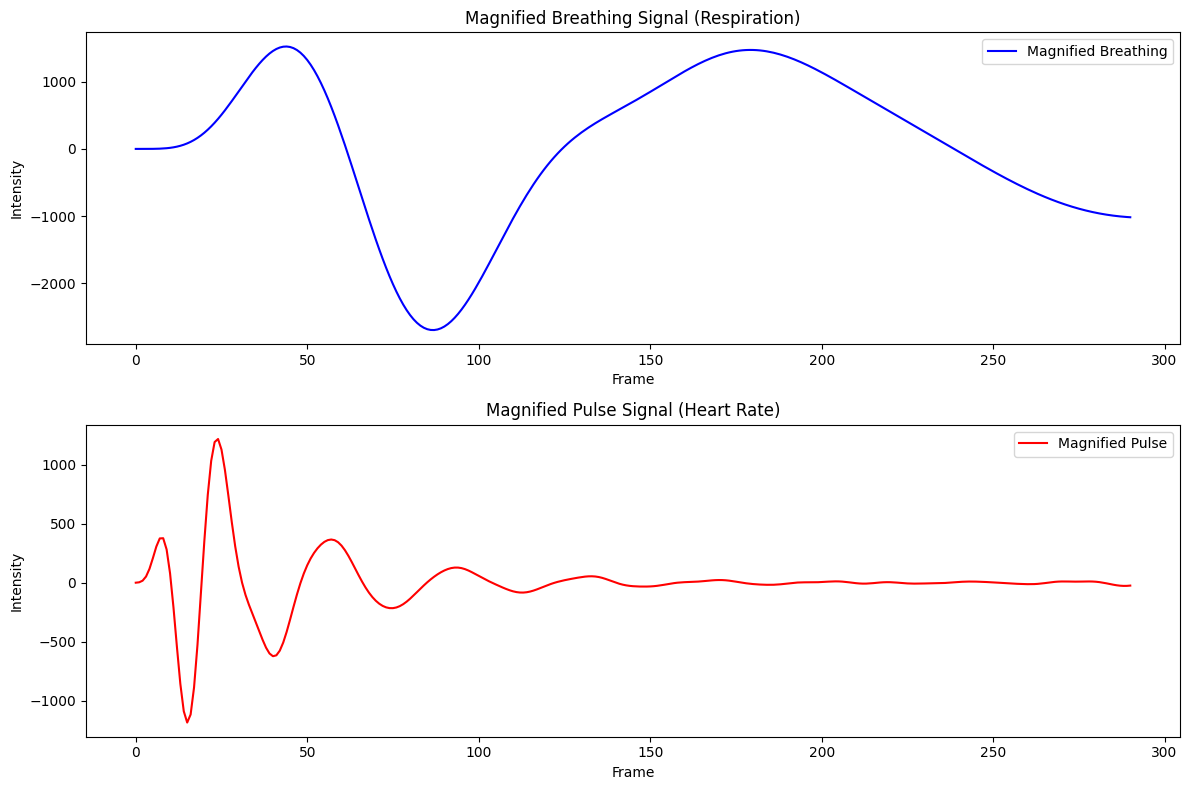

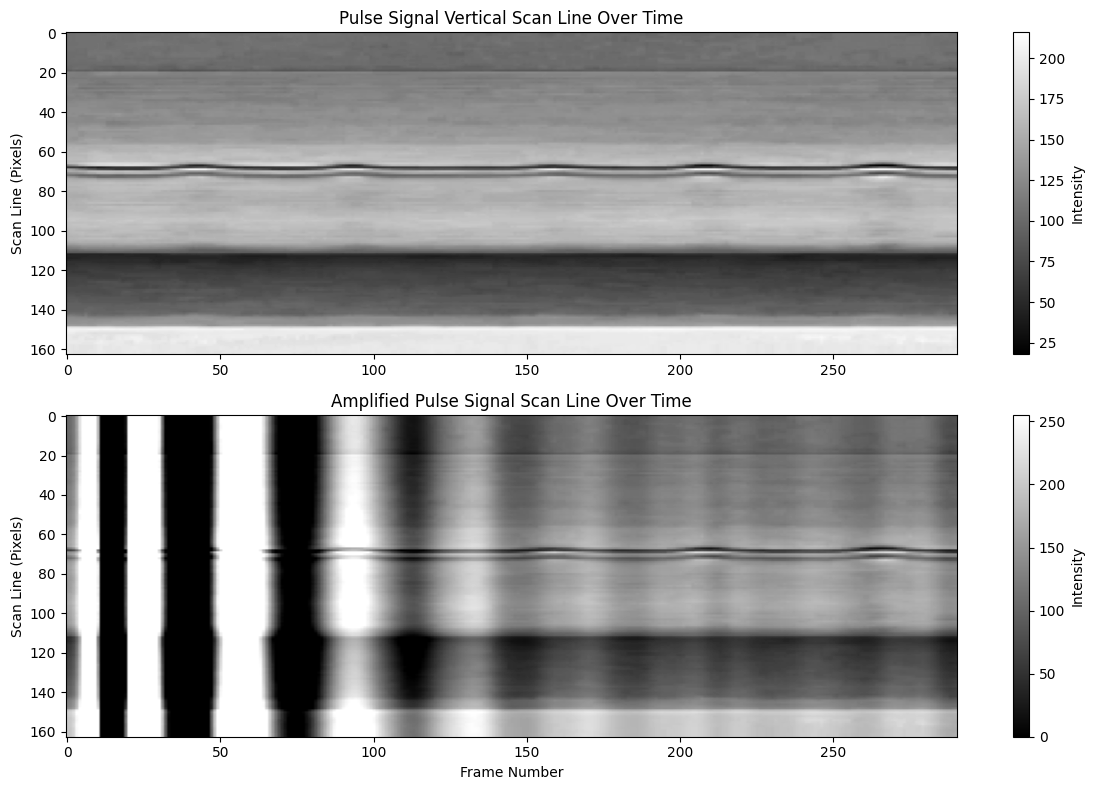

In [ ]:
input_type = "video"
video_path = "/content/321.mp4"
save_video = True


# Run the monitoring system with reduced video quality
status = eulerian_monitoring(
    input_type=input_type,
    video_path=video_path,           # Pulse magnification
    low_breath_freq=0.1,     # Breathing frequency range (Hz)
    high_breath_freq=0.5,
    low_pulse_freq=0.8,      # Pulse frequency range (Hz)
    high_pulse_freq=2.5,
    fps=30,                  # Default FPS for webcam
    resize_factor=0.3,       # Reduced frame size for memory efficiency
    duration=60,             # Monitoring duration (in seconds)
    save_video=save_video,
    output_file="/content/magnified_output.avi"
)


Resolution: 216x384, FPS: 59
Monitoring started... Press 'Q' to stop.
Breathing Rate: 0.79 BPM
Pulse Rate: 69.93 BPM
Irregularity Score: 0.00
Status: Normal


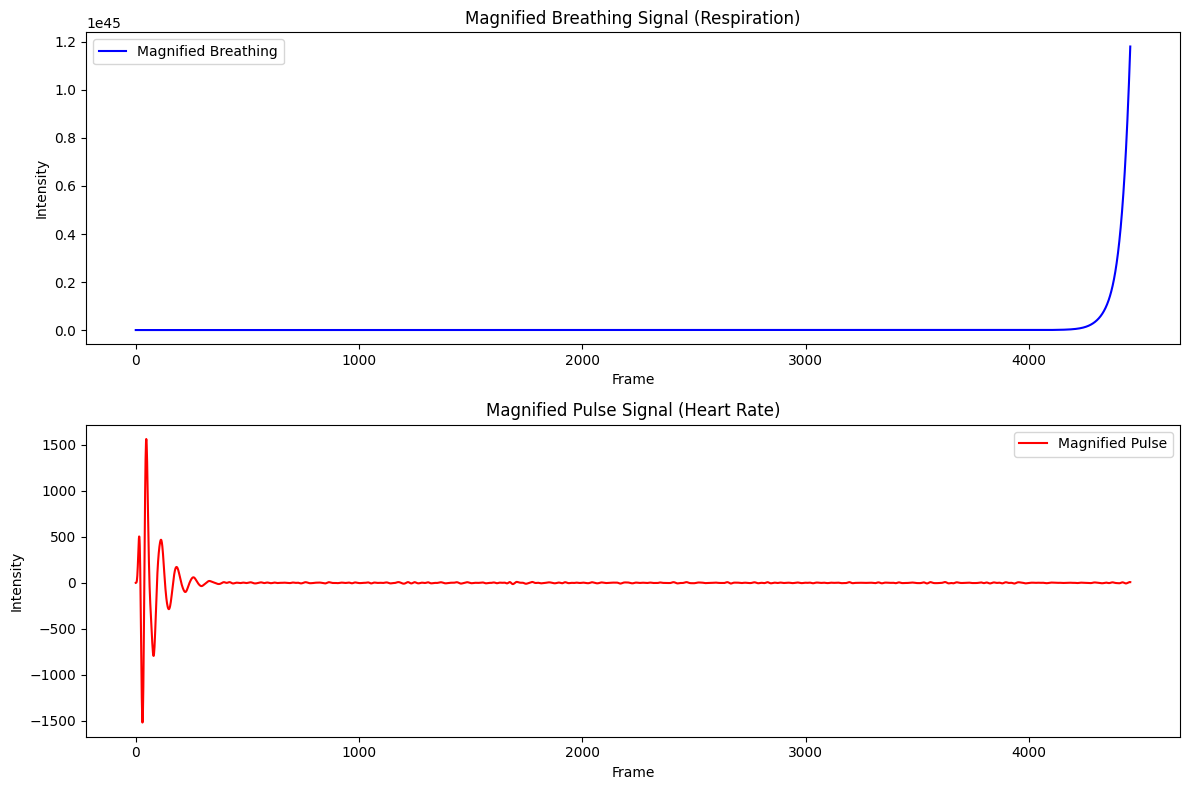

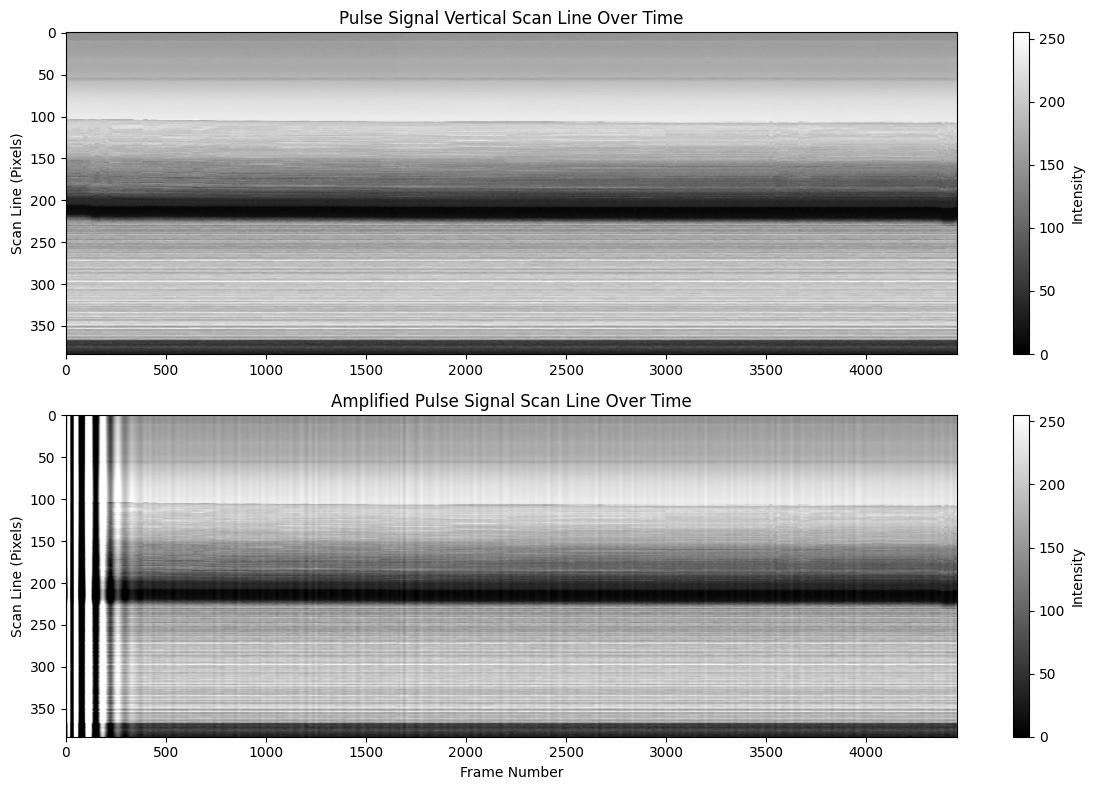

In [ ]:
# Run the monitoring system with reduced video quality
status = eulerian_monitoring(
    video_path='/content/123.mp4',
    save_video=True,
    output_file="/content/magnified_output.avi"
)
